In [ ]:
!pip install autograd

In [ ]:
from sgd_robust_regression import *
import pandas as pd
from scipy import stats
import scipy as sp

In [ ]:
nu = 5
N = 10000
D = 10
eta = 0.2
eta0 = 5
alpha = 0.51
batchsize = 10
iter_percentage = 0.0
num_test = 20
iterations = 1000
init_param = np.zeros(D+1)
error_threshold = 5

In [ ]:
def run_SGD_modified(strategy, grad_loss, init_param, eta , eta0, alpha, batchsize, N, iter_percentage, iterations, epochs = False):
    D = init_param.size
    if epochs:
      iters = int(epochs*N/batchsize)
    else:
      iters = iterations
    parameters = np.zeros((iters+1,D))
    parameters[0] = init_param

    for k in range(iters):
        inds = np.random.choice(N, batchsize)

        if strategy == 'constant' or strategy == 'average':
            stepsize = eta

        elif strategy == 'decreasing':
            stepsize = eta0 / (k+1)**alpha

        parameters[k+1] = parameters[k] - stepsize *  grad_loss(parameters[k], inds)

    if strategy == 'average':
      return np.array([np.mean(parameters[i//2:i+1], axis=0) for i in range(iters)])

    return parameters

def check_error_threshold(params, true_params, threshold):
    num_steps = params.shape[0]

    for step in range(num_steps):
        error = np.linalg.norm(params[step, :] - true_params)

        if error >= threshold:
            return step - 1 if step > 0 else -1

    return num_steps - 1

In [ ]:
true_beta, Y, Z = generate_data(N, D, seed = 100)
sgd_loss, grad_sgd_loss = make_sgd_robust_loss(Y, Z, nu)

def wrapper(param):
    return sgd_loss(param,np.array(range(N)))

opt_param=sp.optimize.minimize(wrapper, init_param).x

# Number of Iterations

In [ ]:
iter_result = []

for strategy in ['constant']:#,'decreasing','average'

  for test_epoch in np.linspace(0,1000,5)[1:]:
    print(f'Testing {test_epoch:.2f} th test_epoch...')

    for i in range(num_test):
      params = run_SGD_modified(strategy,
                                grad_sgd_loss,
                                init_param,
                                eta,
                                eta0,
                                alpha,
                                batchsize,
                                N,
                                iter_percentage,
                                int(test_epoch))

      iter_result.append({'acc':np.linalg.norm(params[-1] - opt_param)**2,
                           'strategy':strategy,
                           'test_epoch':test_epoch})

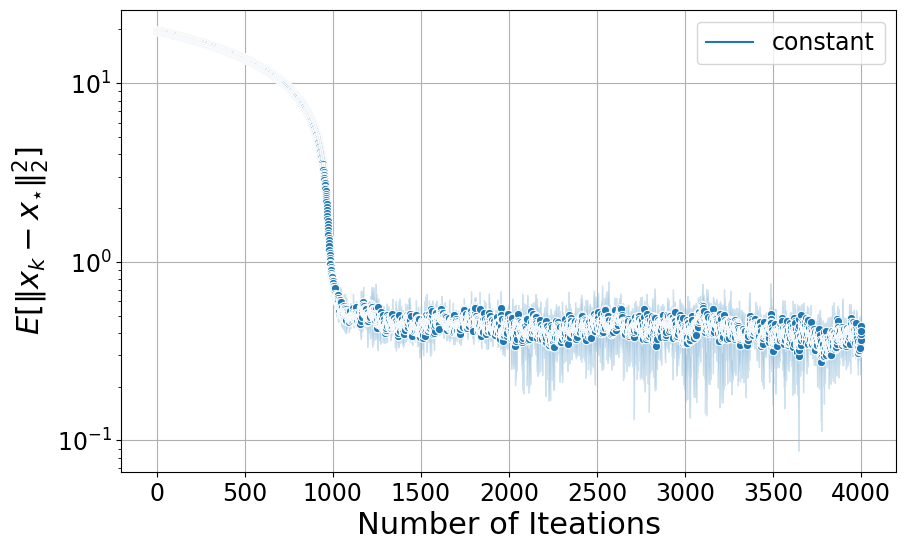

In [ ]:
df = pd.DataFrame(iter_result)

# Plotting using Seaborn's lineplot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='test_epoch', y='acc', errorbar=('ci', 95), marker = 'o', hue = 'strategy')

plt.title(None,fontsize = 17)
plt.yscale('log')
plt.ylabel(r'$E[\|x_k - x_{\star}\|_2^2]$',fontsize = 22)
plt.xlabel('Number of Iteations',fontsize = 22)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)
plt.legend(title=None,fontsize = 17)
plt.grid(True)
plt.savefig('iterations.pdf',dpi = 300, bbox_inches='tight')

# Initilization Distance

In [ ]:
init_result = []

for strategy in ['constant','decreasing','average']:

    for init_scaler in np.linspace(-5,5,20)[:]:
        print(f'Testing init parameter: {init_scaler:.2f}')
        scaler = np.array([init_scaler for _ in range(opt_param.shape[0])])
        mask = np.random.rand(scaler.shape[0]) < 0.5
        scaler[mask] *= -1

        for i in range(num_test):
            params = run_SGD_modified(strategy,
                                      grad_sgd_loss,
                                      opt_param + scaler,
                                      eta ,
                                      eta0,
                                      alpha,
                                      batchsize,
                                      N,
                                      iter_percentage,
                                      iterations)

            init_result.append({'step':np.argmax((np.linalg.norm(params - opt_param, axis = 1)**2) < error_threshold),
                                'strategy':strategy,
                                'init_scaler':init_scaler})

Testing init parameter: -5.00
Testing init parameter: -4.47
Testing init parameter: -3.95
Testing init parameter: -3.42
Testing init parameter: -2.89
Testing init parameter: -2.37
Testing init parameter: -1.84
Testing init parameter: -1.32
Testing init parameter: -0.79
Testing init parameter: -0.26
Testing init parameter: 0.26
Testing init parameter: 0.79
Testing init parameter: 1.32
Testing init parameter: 1.84
Testing init parameter: 2.37
Testing init parameter: 2.89
Testing init parameter: 3.42
Testing init parameter: 3.95
Testing init parameter: 4.47
Testing init parameter: 5.00
Testing init parameter: -5.00
Testing init parameter: -4.47
Testing init parameter: -3.95
Testing init parameter: -3.42
Testing init parameter: -2.89
Testing init parameter: -2.37
Testing init parameter: -1.84
Testing init parameter: -1.32
Testing init parameter: -0.79
Testing init parameter: -0.26
Testing init parameter: 0.26
Testing init parameter: 0.79
Testing init parameter: 1.32
Testing init parameter:

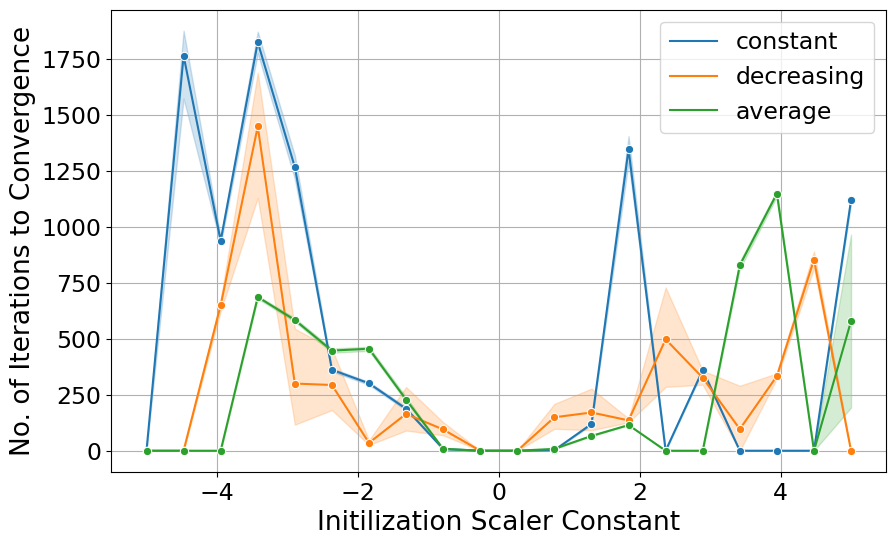

In [ ]:
df = pd.DataFrame(init_result)
df['init_scaler']

# Plotting using Seaborn's lineplot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df,x='init_scaler', y='step', hue='strategy', errorbar=('ci', 95), marker = 'o')

plt.title(None,fontsize = 17)
plt.ylabel('No. of Iterations to Convergence',fontsize = 19)
plt.xlabel('Initilization Scaler Constant',fontsize = 19)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)
plt.legend(title=None,fontsize = 17)
plt.grid(True)
plt.savefig('initialization.pdf',dpi = 300, bbox_inches='tight')

# Step Sizes

In [ ]:
step_result = []

for strategy in ['constant','average']:

  for test_eta in [0.01,0.1,0.2,0.5,1.0,2.0]:
    print(f'Testing step size: {test_eta:.2f}')

    for i in range(num_test):
      params = run_SGD_modified(strategy,
                                grad_sgd_loss,
                                init_param,
                                test_eta,
                                eta0,
                                alpha,
                                batchsize,
                                N,
                                iter_percentage,
                                iterations)

      step_result.append({'acc':np.linalg.norm(params[-1] - opt_param)**2,
                           'strategy':strategy,
                           'test_eta':test_eta})

Testing step size: 0.01
Testing step size: 0.10
Testing step size: 0.20
Testing step size: 0.50
Testing step size: 1.00
Testing step size: 2.00
Testing step size: 0.01
Testing step size: 0.10


KeyboardInterrupt: ignored

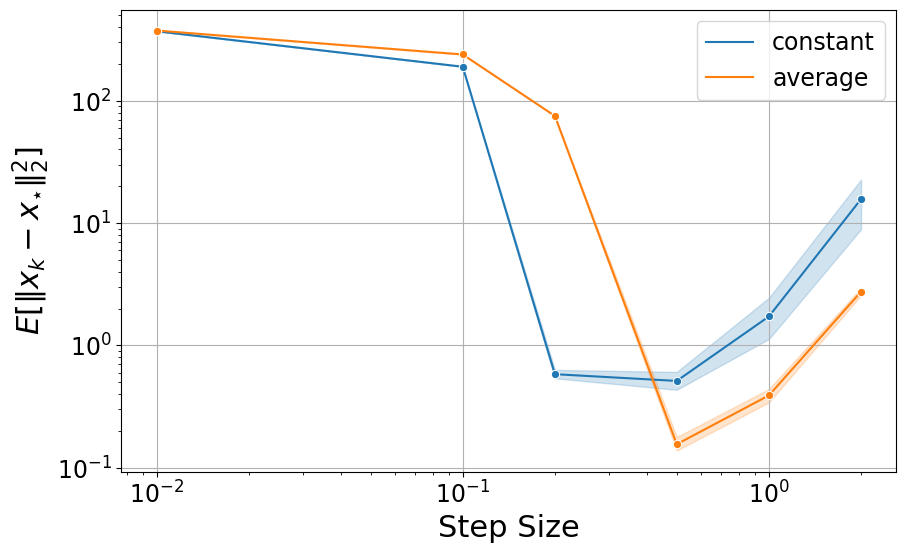

In [ ]:
df = pd.DataFrame(step_result)

# Plotting using Seaborn's lineplot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df,x='test_eta', y='acc', hue='strategy', errorbar=('ci', 95), marker = 'o')

plt.title(None,fontsize = 17)
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'$E[\|x_k - x_{\star}\|_2^2]$',fontsize = 22)
plt.xlabel('Step Size',fontsize = 22)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)
plt.legend(title=None,fontsize = 17)
plt.grid(True)
plt.savefig('stepsize.pdf',dpi = 300, bbox_inches='tight')

In [ ]:
eta0_result = []

for test_eta0 in np.linspace(2.5,13,12)[1:]:
    print(f'Testing eta0: {test_eta0:.2f}')

    for i in range(num_test):
      params = run_SGD_modified('decreasing',
                                grad_sgd_loss,
                                init_param,
                                eta,
                                test_eta0,
                                alpha,
                                batchsize,
                                N,
                                iter_percentage,
                                iterations)

      eta0_result.append({'acc':np.linalg.norm(params[-1] - opt_param)**2,
                          'test_eta0':test_eta0})

Testing eta0: 3.45
Testing eta0: 4.41
Testing eta0: 5.36
Testing eta0: 6.32
Testing eta0: 7.27
Testing eta0: 8.23
Testing eta0: 9.18
Testing eta0: 10.14
Testing eta0: 11.09
Testing eta0: 12.05
Testing eta0: 13.00


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


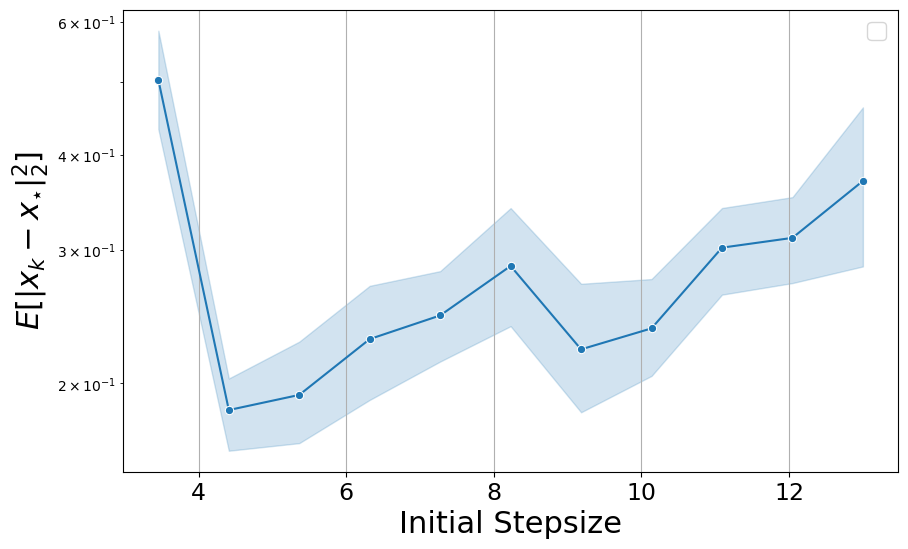

In [ ]:
df = pd.DataFrame(eta0_result)

# Plotting using Seaborn's lineplot
plt.figure(figsize=(10, 6))
plot = sns.lineplot(data=df,x='test_eta0', y='acc',errorbar=('ci', 95), marker = 'o')

plt.title(None,fontsize = 17)
plt.yscale('log')
plt.ylabel(r'$E[\|x_k - x_{\star}\|_2^2]$',fontsize = 22)
plt.xlabel('Initial Stepsize',fontsize = 22)
plt.xticks(fontsize = 17)
plt.legend(title = None,fontsize = 17)
plt.grid(True)
plt.savefig('initstepsize.pdf',dpi = 300, bbox_inches='tight')

In [ ]:
alpha_result = []

for test_alpha in np.linspace(0.51,0.99,12)[:]:
    print(f'Testing alpha: {test_alpha:.2f}')

    for i in range(num_test):
      params = run_SGD_modified('decreasing',
                                grad_sgd_loss,
                                init_param,
                                eta,
                                eta0,
                                test_alpha,
                                batchsize,
                                N,
                                iter_percentage,
                                iterations)

      alpha_result.append({'acc':np.linalg.norm(params[-1] - opt_param)**2,
                           'test_alpha':test_alpha})


Testing alpha: 0.51
Testing alpha: 0.55
Testing alpha: 0.60
Testing alpha: 0.64
Testing alpha: 0.68
Testing alpha: 0.73
Testing alpha: 0.77
Testing alpha: 0.82
Testing alpha: 0.86
Testing alpha: 0.90
Testing alpha: 0.95
Testing alpha: 0.99


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


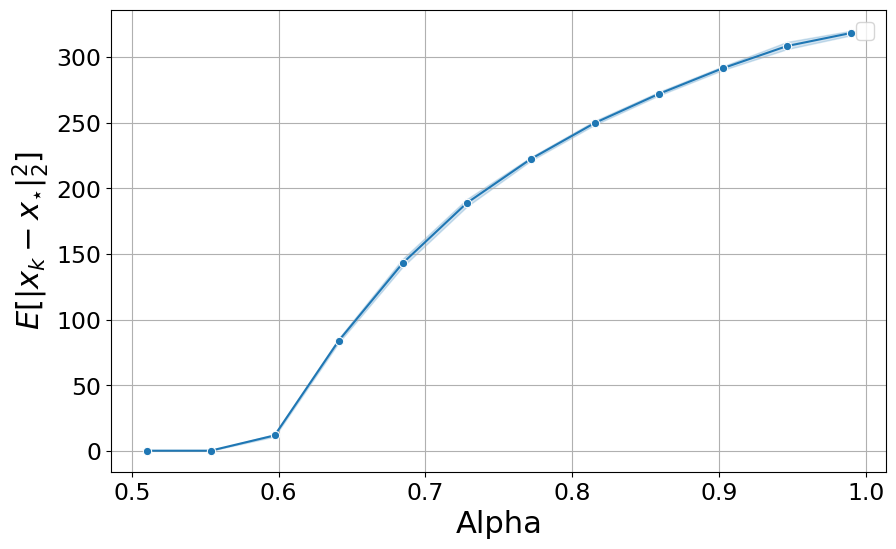

In [ ]:
df = pd.DataFrame(alpha_result)


# Plotting using Seaborn's lineplot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df,x='test_alpha', y='acc',errorbar=('ci', 95), marker = 'o')

plt.title(None,fontsize = 17)
plt.ylabel(r'$E[\|x_k - x_{\star}\|_2^2]$',fontsize = 22)
plt.xlabel('Alpha',fontsize = 22)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)
plt.legend(title=None,fontsize = 17)
plt.grid(True)
plt.savefig('alpha.pdf',dpi = 300, bbox_inches='tight')

# Gradient Noise

In [ ]:
batch_accuracy = []

for strategy in ['constant','decreasing','average']:

    for batch in [1,5,10,20,30,40,50,60,70,80,90,100,110,130,150,200]:
        print(f'Testing batch size: {batch:.2f}')

        for i in range(num_test):

            params = run_SGD_modified(strategy,
                                      grad_sgd_loss,
                                      init_param,
                                      test_eta,
                                      eta0,
                                      alpha,
                                      batch,
                                      N,
                                      iter_percentage,
                                      iterations,
                                      epochs = 10.0)

            batch_accuracy.append({'acc':np.linalg.norm(params[-1] - opt_param)**2,
                           'strategy':strategy,
                           'batch':batch})

Testing batch size: 10.00
Testing batch size: 20.00
Testing batch size: 30.00
Testing batch size: 40.00
Testing batch size: 50.00
Testing batch size: 60.00
Testing batch size: 70.00
Testing batch size: 80.00
Testing batch size: 90.00
Testing batch size: 100.00
Testing batch size: 110.00
Testing batch size: 130.00
Testing batch size: 150.00
Testing batch size: 200.00
Testing batch size: 10.00
Testing batch size: 20.00
Testing batch size: 30.00
Testing batch size: 40.00
Testing batch size: 50.00
Testing batch size: 60.00
Testing batch size: 70.00
Testing batch size: 80.00
Testing batch size: 90.00
Testing batch size: 100.00
Testing batch size: 110.00
Testing batch size: 130.00
Testing batch size: 150.00
Testing batch size: 200.00
Testing batch size: 10.00
Testing batch size: 20.00
Testing batch size: 30.00
Testing batch size: 40.00
Testing batch size: 50.00
Testing batch size: 60.00
Testing batch size: 70.00
Testing batch size: 80.00
Testing batch size: 90.00
Testing batch size: 100.00
T

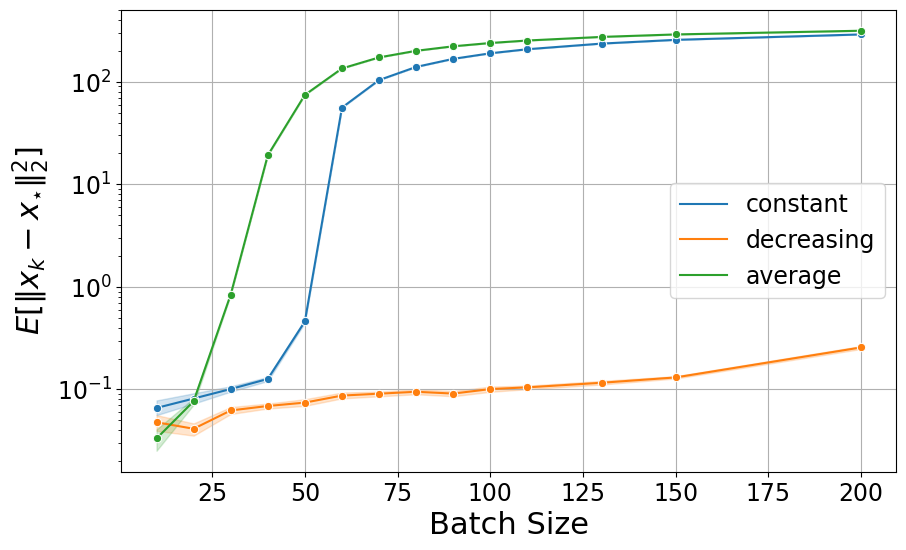

In [ ]:
df = pd.DataFrame(batch_accuracy)

# Plotting using Seaborn's lineplot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df,x='batch', y='acc', hue='strategy', errorbar=('ci', 95), marker = 'o')

plt.title(None,fontsize = 17)
plt.ylabel(r'$E[\|x_k - x_{\star}\|_2^2]$',fontsize = 22)
plt.xlabel('Batch Size',fontsize = 22)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)
plt.legend(title=None,fontsize = 17)
plt.yscale('log')
plt.grid(True)
plt.savefig('batch.pdf',dpi = 300, bbox_inches='tight')

In [ ]:
sgd_loss_new, grad_sgd_loss_new = make_sgd_robust_loss(Y, Z, np.inf)

def wrapper(param):
    return sgd_loss_new(param,np.array(range(N)))

opt_param_new =sp.optimize.minimize(wrapper, init_param).x

In [ ]:
loss_result = []


for strategy in ['constant','decreasing','average']:

  for test_epoch in np.linspace(0,2000,11)[1:]:
    print(f'Testing {test_epoch:.2f} th test_epoch...')

    for i in range(num_test):
      params = run_SGD_modified(strategy,
                                grad_sgd_loss_new,
                                init_param,
                                eta,
                                eta0,
                                alpha,
                                batchsize,
                                N,
                                iter_percentage,
                                int(test_epoch))

      loss_result.append({'acc':np.linalg.norm(params[-1] - opt_param_new)**2,
                           'strategy':strategy,
                           'test_epoch':test_epoch,
                             'loss':'new'})

for strategy in ['constant','decreasing','average']:

  for test_epoch in np.linspace(0,2000,11)[1:]:
    print(f'Testing {test_epoch:.2f} th test_epoch...')

    for i in range(num_test):
      params = run_SGD_modified(strategy,
                                grad_sgd_loss,
                                init_param,
                                eta,
                                eta0,
                                alpha,
                                batchsize,
                                N,
                                iter_percentage,
                                int(test_epoch))

      loss_result.append({'acc':np.linalg.norm(params[-1] - opt_param)**2,
                           'strategy':strategy,
                           'test_epoch':test_epoch,
                         'loss':'old'})

Testing 200.00 th test_epoch...
Testing 400.00 th test_epoch...
Testing 600.00 th test_epoch...
Testing 800.00 th test_epoch...
Testing 1000.00 th test_epoch...
Testing 1200.00 th test_epoch...
Testing 1400.00 th test_epoch...
Testing 1600.00 th test_epoch...
Testing 1800.00 th test_epoch...
Testing 2000.00 th test_epoch...
Testing 200.00 th test_epoch...
Testing 400.00 th test_epoch...
Testing 600.00 th test_epoch...
Testing 800.00 th test_epoch...
Testing 1000.00 th test_epoch...
Testing 1200.00 th test_epoch...
Testing 1400.00 th test_epoch...
Testing 1600.00 th test_epoch...
Testing 1800.00 th test_epoch...
Testing 2000.00 th test_epoch...
Testing 200.00 th test_epoch...
Testing 400.00 th test_epoch...
Testing 600.00 th test_epoch...
Testing 800.00 th test_epoch...
Testing 1000.00 th test_epoch...
Testing 1200.00 th test_epoch...
Testing 1400.00 th test_epoch...
Testing 1600.00 th test_epoch...
Testing 1800.00 th test_epoch...
Testing 2000.00 th test_epoch...
Testing 200.00 th test

In [ ]:
df = pd.DataFrame(loss_result)
df['loss'] = df['loss'].apply(lambda x: 'nu = 5' if x == 'old' else 'nu = infinity')

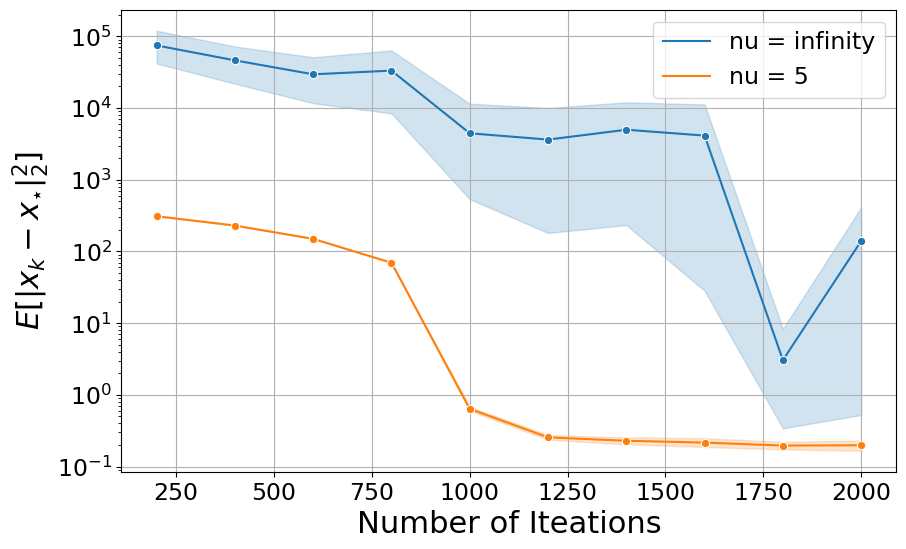

In [ ]:
df = df[df['strategy'] == 'constant']

# Plotting using Seaborn's lineplot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='test_epoch', y='acc', errorbar=('ci', 95), marker = 'o', hue = 'loss')

plt.title(None,fontsize = 17)
plt.yscale('log')
plt.ylabel(r'$E[\|x_k - x_{\star}\|_2^2]$',fontsize = 22)
plt.xlabel('Number of Iteations',fontsize = 22)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)
plt.legend(title=None,fontsize = 17)
plt.grid(True)
plt.savefig('loss_constant.pdf',dpi = 300, bbox_inches='tight')